# Loading data

In [1]:
import numpy as np
import hicstraw

In [41]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# hic = hicstraw.HiCFile("https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic")

In [3]:
hic = hicstraw.HiCFile("GSM1551688_HIC143.hic")

In [7]:
RESOLUTION = 50000

In [8]:
mzd = hic.getMatrixZoomData(
    "4", "4", "observed", "KR", "BP", RESOLUTION
) 

In [90]:
numpy_matrix_chr4 = mzd.getRecordsAsMatrix(0, 8000000, 0, 8000000)

In [91]:
numpy_matrix_chr4

array([[15.57630444,  2.69259524,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.69259524, 24.43638992,  1.25475776, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.25475776, 16.67105484, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 19.26651764,
         2.87969303,  1.6656872 ],
       [ 0.        ,  0.        ,  0.        , ...,  2.87969303,
        13.15162182,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.6656872 ,
         0.        , 13.50065899]])

In [92]:
numpy_matrix_chr4.shape

(161, 161)

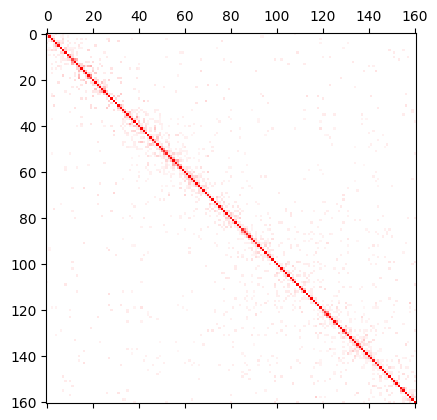

In [44]:
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1, 1, 1), (1, 0, 0)])


# helper function for plotting
def plot_hic_map(dense_matrix, maxcolor, tads = None):
    # TAD communities and matrix must be on the same resolution, otherwise it wont work
    fig, ax = plt.subplots()
    ax.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    if tads:
        for tad in tads:
            rect = patches.Rectangle((tad[0], tad[0]), len(tad), len(tad), linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)
plt.show()


plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2)

In [13]:
import juicebox_notebook

In [14]:
juicebox_notebook.init()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
b = juicebox_notebook.Browser(
    {  # load hic via URL
        "name": "GM12878",
        "locus": "2:3,319,567-30,009,566",
        "url": "https://www.encodeproject.org/files/ENCFF718AWL/@@download/ENCFF718AWL.hic",
        "normalization": "KR",
    }
)

<IPython.core.display.Javascript object>

# Arrowhead

In [16]:
# java -jar juicer_tools_1.22.01.jar arrowhead <options, eg: > -k NONE -r 5000 hic_data/inter_30.hic test --ignore-sparsity

## Links

[Main juicer repo (git clone)](https://github.com/aidenlab/juicer)   
[Arrowhead jar download](https://github.com/aidenlab/juicer/wiki/Download)   
[Arrowhead use instruction](https://github.com/aidenlab/juicer/wiki/Arrowhead)  

# Algorithm

In [68]:
import numpy as np
from sklearn.metrics import adjusted_rand_score

In [103]:
import random
import copy


class ModLouvien:
    def __init__(self, A, gamma, N = 100,  eps=1e-10, seed=None):
        self.A = A
        self.gamma = gamma
        self.N = N # number of times to run the algorithm
        self.classes = [
            i for i in range(len(A))
        ]  # communities assignments, at first -- each node to different community
        self.eps = eps  # for stopping condition

        if seed:
            random.seed(seed)

    def run(self, verbose=False):
        # main function to use "outside" -- algorithm is run N times, and then aggregated -- https://www.biorxiv.org/content/10.1101/089011v1.full
        N_communities = []
        N_communities_indexes = []
        for i in range(self.N):
            if verbose:
                print(f"Algorithm run {i+1}...")
            community, idxes = self._run_algorithm(verbose)
            N_communities.append(community)
            N_communities_indexes.append(idxes)
        best_index = self.aggregate_results(N_communities_indexes)
        return N_communities[best_index]

    def aggregate_results(self, communities):
        num_comm = len(communities)
        pairwise_rand = np.zeros((num_comm,num_comm))
    
        for i in range(num_comm):
        	for j in range(num_comm):
        		pairwise_rand[i,j] = adjusted_rand_score(communities[i], communities[j])
    
        avg_pairwise_rand = np.average(pairwise_rand, axis = 0)
    
        idx = np.argmax(avg_pairwise_rand)
    
        return idx

    def community_to_indexes(self):
        # transform community lists to indexes (each element gest community index)
        idxes = []
        for i in range(len(self.communities)):
            idxes.extend([i for _ in range(len(self.communities[i]))])
        return idxes

    def _run_algorithm(self, verbose):
        # main algorithm function, implements version from https://www.biorxiv.org/content/10.1101/089011v1.full
        A, classes = self.A, self.classes
        rowsum = np.sum(A, axis=1)
        rowcolsums = np.outer(
            rowsum, rowsum
        ) # matrix witk k_ik_j, for speeding up Q computation
        self.communities = [[i] for i in range(len(self.classes))]  # final communities
          
        Q_prev = -1
        Q_curr = self.compute_Q(A, classes, rowcolsums)
        while Q_curr - Q_prev > self.eps:
            Q_prev = Q_curr
            rand_idx = list(
                range(len(classes))
            )  # We permute indexes randomly each time
            random.shuffle(rand_idx)
            for i in rand_idx:
                # switching left/right neighbour and comparing if Q increased
                i_left = max(0, i - 1)
                i_right = min(len(rand_idx) - 1, i + 1)

                classes_left = copy.copy(classes)
                classes_left[i_left] = classes_left[i]
                classes_right = copy.copy(classes)
                classes_right[i_right] = classes_right[i]

                Q_left = self.compute_Q(A, classes_left, rowcolsums)
                Q_right = self.compute_Q(A, classes_right, rowcolsums)
                Q_max = max(Q_curr, Q_left, Q_right)
                if Q_max == Q_left:
                    classes = classes_left
                    Q_curr = Q_left
                if Q_max == Q_right:
                    classes = classes_right
                    Q_curr = Q_right

            A, classes, rowcolsums = self.consolidate_communities(A, classes)
            if len(classes) <= 1:
                break
            if verbose:
                print(f"Current Q: {Q_curr}")
                print(f"Prev Q: {Q_prev}")
                print("-------------------------")
        commmunity_idxes = self.community_to_indexes()
        return self.communities, commmunity_idxes

    def consolidate_communities(self, A, classes):
        # Communities consolidation - we recalculate A and classes so that we get A and classes for new communities
        new_classes = []
        indices = []
        curr_indices = []
        # creating new_classes
        for i in range(1, len(classes)):
            curr_indices.append(i - 1)
            if classes[i - 1] != classes[i]:
                new_classes.append(classes[i - 1])
                indices.append(curr_indices)
                curr_indices = []
        curr_indices.append(len(classes) - 1)
        indices.append(curr_indices)
        new_classes.append(len(classes) - 1)

        new_A = np.zeros((len(new_classes), len(new_classes)))
        for i in range(len(indices)):
            for j in range(len(indices)):
                for k in indices[i]:
                    for l in indices[j]:
                        new_A[i, j] += A[k, l]
        rowsum = np.sum(new_A, axis=1)
        rowcolsums = np.outer(rowsum, rowsum)
        self.update_global_communities(indices)
        return new_A, new_classes, rowcolsums

    def update_global_communities(self, indices):
        # updating global communities assignments
        new_communities = [[] for _ in range(len(indices))]
        for i in range(len(indices)):
            for j in indices[i]:
                new_communities[i] += self.communities[j]

        self.communities = new_communities

    def compute_Q(self, A, classes, rowcolsums):
        # Q computation from the formula from article -- using numpy einsum for faster computation
        Q = 0
        m = np.sum(A)
        delta = np.equal.outer(classes, classes)
        Q = np.sum((A - self.gamma * rowcolsums / m) * delta)
        return Q / m

In [104]:
lv = ModLouvien(numpy_matrix_chr4, 1.5)

In [105]:
communities = lv.run(verbose=False)

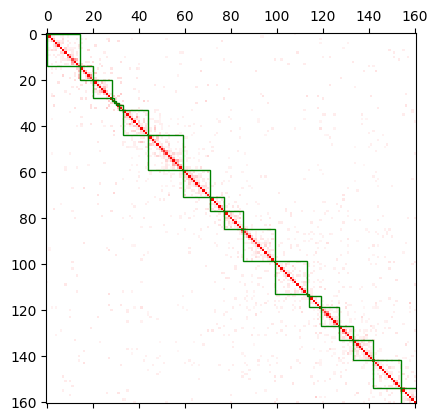

In [106]:
plot_hic_map(numpy_matrix_chr4, numpy_matrix_chr4.max() / 2, communities)

In [34]:
def communities_to_coords(communities, resolution):
    coords = []
    for community in communities:
        coords.append([community[0]*resolution, community[-1]*resolution])
    return coords
        

In [35]:
communities_to_coords(communities, RESOLUTION)

[[0, 500000],
 [550000, 950000],
 [1000000, 1250000],
 [1300000, 1600000],
 [1650000, 2150000],
 [2200000, 2900000],
 [2950000, 3550000],
 [3600000, 3600000],
 [3650000, 4200000],
 [4250000, 4900000],
 [4950000, 5600000],
 [5650000, 5650000],
 [5700000, 5900000],
 [5950000, 6300000],
 [6350000, 7050000],
 [7100000, 7650000],
 [7700000, 8000000]]

In [37]:
%%timeit
ModLouvien(numpy_matrix_chr4, 1.5).run_algorithm(verbose=False)

67.9 ms ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
